For the Unet architecture I created this notebook to run and test the results.

In [1]:
from unet_zf import ZF_UNET_224
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers.core import Activation
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, LambdaCallback,ModelCheckpoint, CSVLogger
import numpy as np

#own py
import streaming_unet_data
from utility_methods import collect_and_separate_labels, collect_labels,save_plots, save_plots_callback

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
O:\ProgrammingSoftwares\anaconda_projects\dp_nagyhazi\src\utility_methods.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by th

First create Unet architecture. I used https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model repository to collect the pretrained unet architecture. I downloaded separately the pretrained weights. I load up the weights, after that i modify the architecture.

In [9]:
model = ZF_UNET_224(weights='generator')
optim = Adam()
model.compile(optimizer=optim, loss='mse', metrics=['accuracy'])

In [10]:
model.summary()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()

conv_out = Conv2D(2, (1, 1), padding='same')(model.layers[-1].output)
o = Activation('tanh', name='loss')(conv_out)

model2 = Model(input=model.input, output=[o])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 224, 224, 32) 128         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 224, 224, 32) 0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
conv2d_27 

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [10]:
model2.save('starting_unet.h5')

In [11]:
import keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [12]:
model_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181203_unet_2channel_output/unet_weights.hdf5'
image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
model2.load_weights(model_folder)
#model2 = load_model(model_folder)

In [7]:
for layer in model2.layers[:-7]:
    layer.trainable = False

In [10]:

patience=15
early_stopping=EarlyStopping(monitor='loss',patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='unet_test_weights.hdf5', monitor='loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger('unet_test_training.log', append=True)

traain = streaming_unet_data.StreamingUnet_DataGenerator(image_folder,batch_size=16)



model2.compile(loss = euclidean_distance_loss, optimizer='rmsprop')

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Length of image list:  15


In [50]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
history = model2.fit_generator(generator=traain,
                    validation_data=traain,
                    epochs=30,
                    callbacks=[csv_logger,checkpointer, early_stopping])

Epoch 1/30
1/1 [==============================] - 78s 78s/step - loss: 0.2903 - val_loss: 1.7968

Epoch 00001: loss improved from inf to 0.29033, saving model to unet_test_weights.hdf5
Epoch 2/30
1/1 [==============================] - 69s 69s/step - loss: 0.9076 - val_loss: 1.7940

Epoch 00002: loss did not improve from 0.29033
Epoch 3/30
1/1 [==============================] - 68s 68s/step - loss: 0.7223 - val_loss: 1.1137

Epoch 00003: loss did not improve from 0.29033
Epoch 4/30
1/1 [==============================] - 71s 71s/step - loss: 0.5676 - val_loss: 1.5788

Epoch 00004: loss did not improve from 0.29033
Epoch 5/30
1/1 [==============================] - 72s 72s/step - loss: 0.6796 - val_loss: 1.1836

Epoch 00005: loss did not improve from 0.29033
Epoch 6/30
1/1 [==============================] - 62s 62s/step - loss: 0.5023 - val_loss: 1.6017

Epoch 00006: loss did not improve from 0.29033
Epoch 7/30
1/1 [==============================] - 61s 61s/step - loss: 0.4782 - val_loss: 

KeyboardInterrupt: 

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\keras_preprocessing\image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Length of image list:  15


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


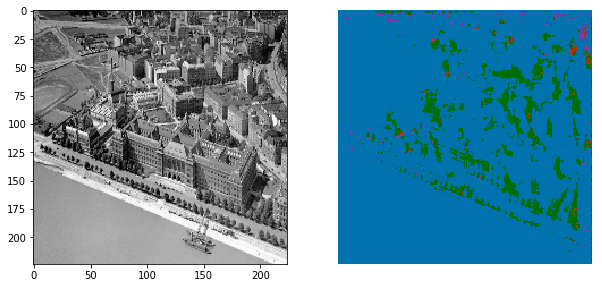

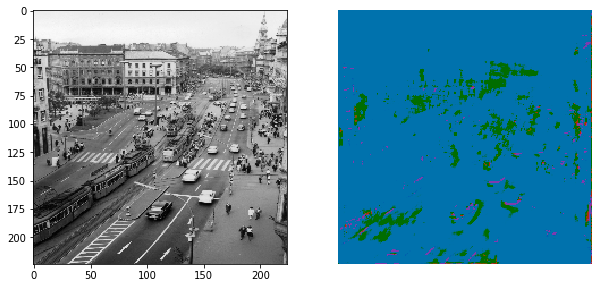

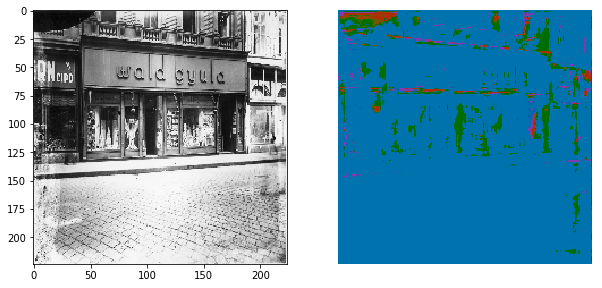

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


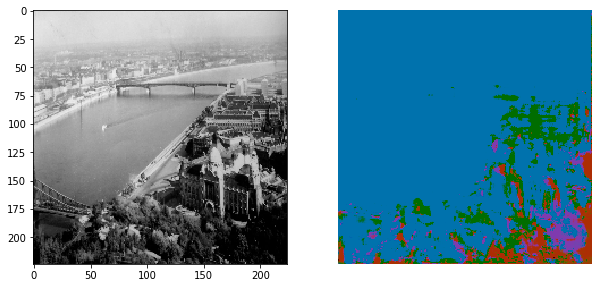

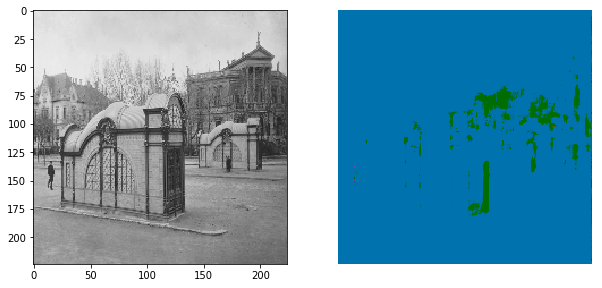

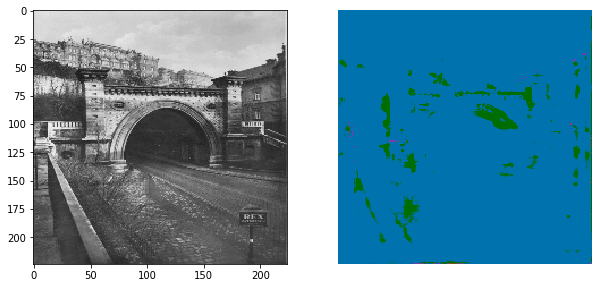

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


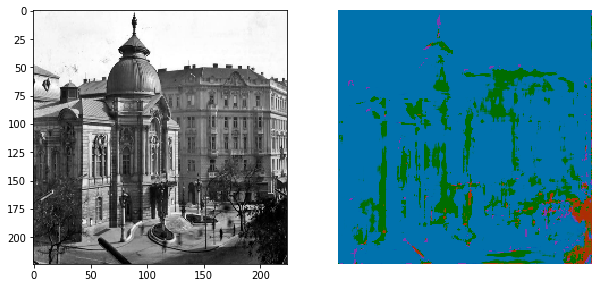

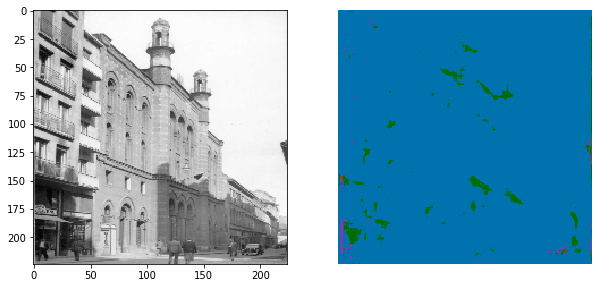

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


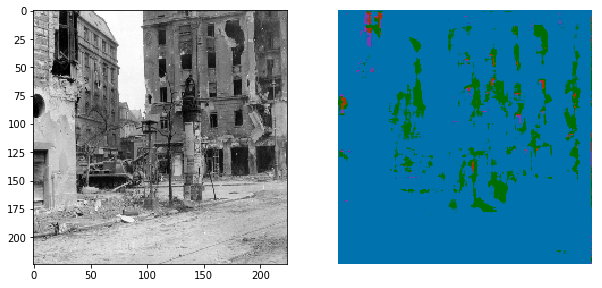

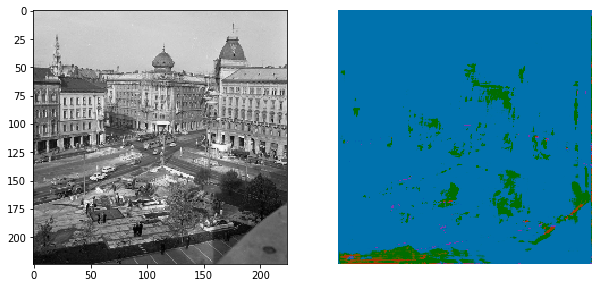

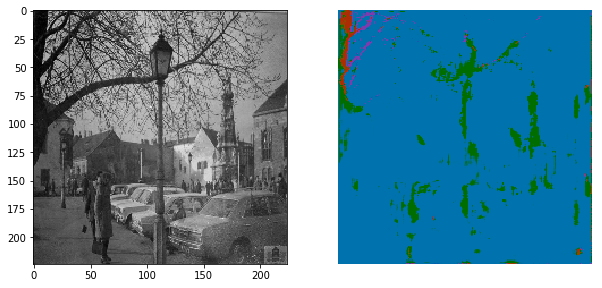

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


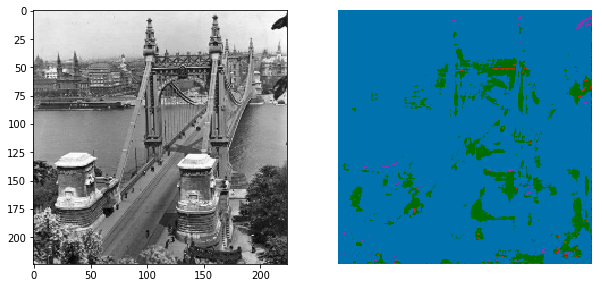

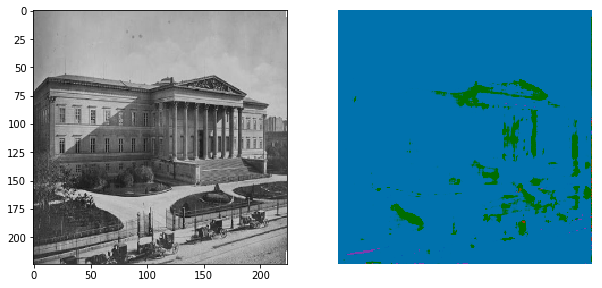

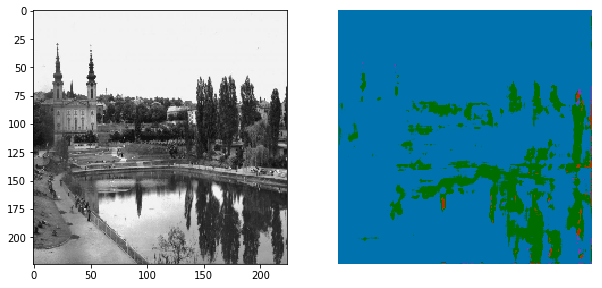

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


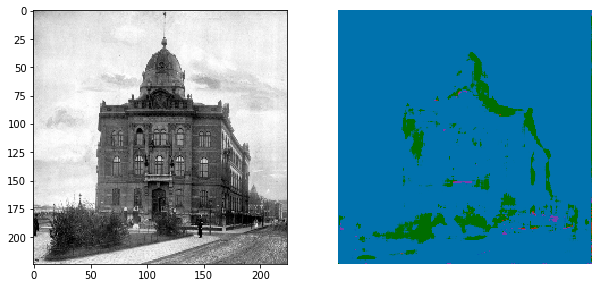

In [26]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import transform, io, color

from importlib import reload  # Python 3.4+ only.
streaming_data = reload(streaming_unet_data)

root_pictures = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181203_unet/legacy/'
watcher = streaming_unet_data.StreamingUnet_DataGenerator(image_folder,batch_size=1, random_trf= False)

for idx in range(len(watcher)):
    X,Y = watcher[idx]
    fig, ax= plt.subplots(1,2,figsize=(10, 10)) 
    plt.axis('off')
    ax[0].imshow(watcher.gray_img[0]/255)

    rgb_img = conc_pred(model2, X, watcher)
    ax[1].imshow(rgb_img)
    plt.axis('off')
    plt.savefig(root_pictures + 'test_img'+str(idx)+'.png', bbox_inches='tight')
    plt.show()

In [27]:
def conc_pred(model, X, watcher, Y = None):
    y_real = model.predict(X)[0]
    if (Y is not None):
        y_real = Y
    y_real = y_real.astype(np.float64)
    y_real = np.clip(y_real,-1,1)
    y_real[:,:,0] = (y_real[:,:,0]) * 50
    y_real[:,:,1] = (y_real[:,:,1]) * 50
    
    lab_im = np.concatenate([X[0,:,:,0, np.newaxis]/255*100,y_real[:,:,0, np.newaxis], y_real[:,:,1, np.newaxis]], axis = 2)
    rgb_img = color.lab2rgb(lab_im)

    
    return rgb_img